Medidas de precisión del modelo ajustado: {'RMSE': 261.49176379076664, 'MAE': 186.37324188377485, 'R2 Score': 0.6325776201214077}


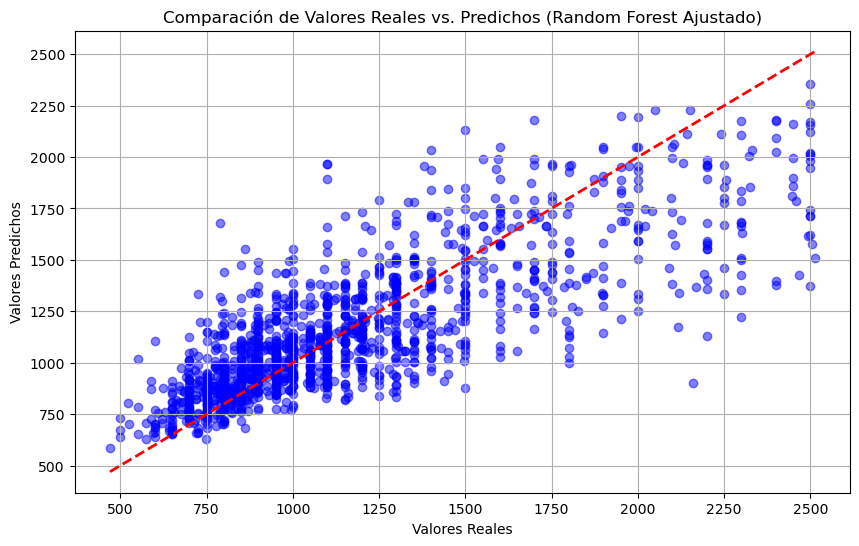

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Cargar el archivo CSV limpio
file_path = 'data_CLEAN.csv'
df_clean = pd.read_csv(file_path)

# Variables predictoras y objetivo
X = df_clean[['rooms', 'bathroom', 'lift', 'terrace', 'square_meters', 'neighborhood', 'real_state']]
y = df_clean['price']

# Convertir las variables categóricas en numéricas con One-Hot Encoding
categorical_features = ['neighborhood', 'real_state']

# Crear un preprocesador con OneHotEncoder para las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Dividir el dataset en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo Random Forest en un pipeline con el preprocesador
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Definir los hiperparámetros a ajustar en RandomizedSearchCV
param_distributions = {
    'model__n_estimators': [500, 750, 1000],  # Aumentamos el rango de árboles
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_distributions, 
    n_iter=50,  # Número de iteraciones aleatorias
    cv=3,  # Validación cruzada de 3 pliegues
    scoring='neg_mean_squared_error',  # Métrica para optimizar
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Entrenar RandomizedSearchCV
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados y entrenar el modelo final
best_rf_model = random_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# Calcular las medidas de precisión del modelo ajustado
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Mostrar las nuevas medidas de precisión
precision_measures_best = {
    'RMSE': rmse_best,
    'MAE': mae_best,
    'R2 Score': r2_best
}
print("Medidas de precisión del modelo ajustado:", precision_measures_best)

# Visualizar la comparación entre los valores reales y los predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, linestyle='--')
plt.title('Comparación de Valores Reales vs. Predichos (Random Forest Ajustado)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()


## Interpretación de los Resultados
RMSE y MAE:

- Estos valores indican que, en promedio, las predicciones del modelo tienen un error de alrededor de 261.49 euros (RMSE) y 186.37 euros (MAE). 
- Cuanto más bajos sean estos valores, mejor es el modelo.
- Aunque estos valores son razonables, podría haber margen para mejorar la precisión.

R2 Score:

- Un valor de 0.63 sugiere que el modelo explica el 63% de la variabilidad en los precios de las propiedades.
- Esto indica un buen ajuste, pero no es perfecto, lo que significa que hay un 37% de la variabilidad que el modelo no está capturando.